<a href="https://colab.research.google.com/github/AndreaM1996/Autoencoder-for-Physical-Layer/blob/master/Gmpi_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.layers import Input, Dense, Lambda, Embedding, Layer, Lambda
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
n = 1
k = 1
M = 2**k
R = k/n

# **Load data**

In [0]:
rng = np.random.default_rng()
train1 = rng.integers(0, M, size=16000)
train2 = rng.integers(0, M, size=16000)
val1 = rng.integers(0, M, size=50000)
val2 = rng.integers(0, M, size=50000)
test1 = rng.integers(0, M, size=100000)
test2 = rng.integers(0, M, size=100000)

In [0]:
x_train1 = np.reshape(train1, (len(train1), 1))
x_train2 = np.reshape(train2, (len(train2), 1))
x_val1 = np.reshape(val1, (len(val1), 1))
x_val2 = np.reshape(val2, (len(val2), 1))
x_test1 = np.reshape(test1, (len(test1), 1))
x_test2 = np.reshape(test2, (len(test2), 1))

# **Autoencoder**

In [0]:
class Channel(Layer):
  def __init__(self, std, **kwargs):
    self.std = std
    self.result = None
    super(Channel, self).__init__(**kwargs)

  def build(self, input_shape):
    assert isinstance(input_shape, list)
    # Create a trainable weight variable for this layer.
    #self.kernel = self.add_weight(name='kernel', shape=(input_shape[0][1], self.output_dim), initializer='uniform', trainable=True)
    super(Channel, self).build(input_shape)  # Be sure to call this at the end

  def call(self, x):
    assert isinstance(x, list)
    x0 = x[0]
    x1 = x[1]
    n1 = K.random_normal(shape=(K.int_shape(x0)[1],K.int_shape(x0)[2]), mean=0, stddev=self.std, seed=42)
    n2 = K.random_normal(shape=(K.int_shape(x1)[1],K.int_shape(x1)[2]), mean=0, stddev=self.std, seed=42)
    self.result = [x0 + x1 + n1, x0 + x1 + n2]
    return self.result

  def compute_output_shape(self, input_shape):
    assert isinstance(input_shape, list)
    return  K.int_shape(self.result)

In [0]:
#tf.keras.losses.Loss
class DynamicWeight(Callback):
  def __init__(self,alpha):
    self.alpha = alpha
    
  def on_epoch_end(self, epoch, logs={}):
    #l1 = K.sparse_categorical_crossentropy(y_true[0],y_pred[0])
    #l2 = K.sparse_categorical_crossentropy(y_true[1], y_pred[1])
    l1 = logs.get('decoder_layer2_1_loss')
    l2 = logs.get('decoder_layer2_2_loss')

    temp = l1 / (l1 + l2)
    K.set_value(self.alpha, temp)
    print("selfalpha %f" % K.get_value(self.alpha))

In [0]:
def encoder(input_, in_dim, n_dim, i):
  encoded1 = Embedding(input_dim=in_dim, output_dim=in_dim, input_length=1, name='encoder_layer1_'+i)(input_)
  encoded2 = Dense(n_dim, activation='linear', name='encoder_layer2_'+i)(encoded1)
  # Normalization
  normalized = Lambda(lambda x: math.sqrt(n_dim) * K.l2_normalize(x, axis=2), name='normalization'+i)(encoded2)
  return normalized

def decoder(encoded, in_dim, i):
  decoded1 = Dense(in_dim, activation='relu', name='decoder_layer1_'+i)(encoded)
  decoded2 = Dense(in_dim, activation='softmax', name='decoder_layer2_'+i)(decoded1)
  return decoded2

def autoencoder(in_dim, n_dim, std, alpha):
  
  transmitter1 = Input(shape=(1,), name='transmitter1')
  transmitter2 = Input(shape=(1,), name='transmitter2')

  # Encoder
  x1 = encoder(transmitter1, in_dim, n_dim,'1')
  x2 = encoder(transmitter2, in_dim, n_dim,'2')

  # Channel
  received = Channel(std)([x1, x2])

  # Decoder
  receiver1 = decoder(received[0], in_dim, '1')
  receiver2 = decoder(received[1], in_dim, '2')

  # Combine Encoder and Decoder layers
  autoencoder = Model(inputs = [transmitter1, transmitter2], outputs = [receiver1, receiver2])

  # Compile the Model
  adam = optimizers.Adam(lr=0.001) 
  autoencoder.compile(optimizer=adam, loss='sparse_categorical_crossentropy', loss_weights= [alpha, 1-alpha],metrics=['sparse_categorical_accuracy'])

  return autoencoder

# **Training and performance**

In [0]:
Eb_No = 10**(7/10)
std = math.sqrt(1/(2 * R * Eb_No))
ae = autoencoder(M, n, std)

In [0]:
ae.summary()

In [0]:
def bler(model, true):
  y_pred = model.predict(true)
  y1 = y_pred[0]
  y2 = y_pred[1]
  pred1 = y1[:,0,:]
  pred2 = y2[:,0,:]
  indices1 = np.argmax(pred1, axis=1)
  indices2 = np.argmax(pred2, axis=1)
  predicted = np.concatenate((indices1, indices2), axis=None)
  
  actual = np.concatenate((true[0], true[1]), axis=None)
  
  diff = np.sum(actual != predicted)
  bler = diff / predicted.shape[0]
  return bler

def plot_bler_vs_ebno(blers, ebno):
  plt.figure(figsize=(6,6))
  plt.scatter(ebno, blers)
  plt.plot(ebno, blers, label='autoencoder (2,2)')
  plt.yscale('log')
  plt.legend()
  plt.show()


In [0]:
snr = range(11)
blers = []
for db in snr:
  Eb_No = 10**(db/10)
  std = math.sqrt(1/(2 * R * Eb_No))
  alpha = K.variable(0.5)
  ae = autoencoder(M, n, std, alpha)
  history = ae.fit(x=[x_train1,x_train2], y=[x_train1,x_train2], epochs = 50, batch_size = 100, shuffle = True, validation_data = ([x_val1, x_val2], [x_val1, x_val2]), callbacks=[DynamicWeight(alpha)])
  error_test = bler(ae, [x_test1,x_test2])
  blers.append(error_test)

Epoch 1/50
160/160 [==============================] - 1s 7ms/step - loss: 0.6522 - decoder_layer2_1_loss: 0.6080 - decoder_layer2_2_loss: 0.6964 - decoder_layer2_1_sparse_categorical_accuracy: 0.7133 - decoder_layer2_2_sparse_categorical_accuracy: 0.5148 - val_loss: 0.6582 - val_decoder_layer2_1_loss: 0.6221 - val_decoder_layer2_2_loss: 0.6943 - val_decoder_layer2_1_sparse_categorical_accuracy: 0.7422 - val_decoder_layer2_2_sparse_categorical_accuracy: 0.4986
Epoch 2/50
160/160 [==============================] - 1s 5ms/step - loss: 0.6295 - decoder_layer2_1_loss: 0.6060 - decoder_layer2_2_loss: 0.6940 - decoder_layer2_1_sparse_categorical_accuracy: 0.7612 - decoder_layer2_2_sparse_categorical_accuracy: 0.5002 - val_loss: 0.6248 - val_decoder_layer2_1_loss: 0.5964 - val_decoder_layer2_2_loss: 0.6937 - val_decoder_layer2_1_sparse_categorical_accuracy: 0.7694 - val_decoder_layer2_2_sparse_categorical_accuracy: 0.4982
Epoch 3/50
160/160 [==============================] - 1s 5ms/step - loss

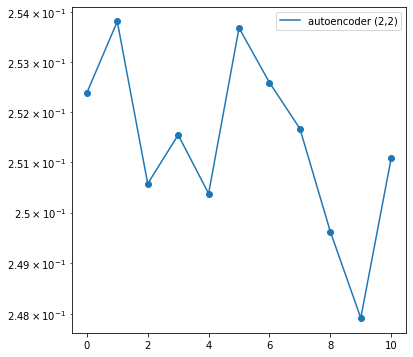

In [0]:
plot_bler_vs_ebno(blers, snr)

In [0]:
blers

[0.252385,
 0.253815,
 0.250575,
 0.251545,
 0.25038,
 0.253685,
 0.25259,
 0.25167,
 0.249625,
 0.247925,
 0.251085]